<a href="https://colab.research.google.com/github/Kiran-01/Conditional-ProductImage-Generation/blob/main/CONDITIONAL_FASHION_PRODUCT_IMAGE_GENERATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# loading fashion MNIST dataset

from keras.datasets.fashion_mnist import load_data

In [ ]:
# example of training an conditional gan on the fashion mnist dataset
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate

4431872/4422102 [==============================] - 0s 0us/step


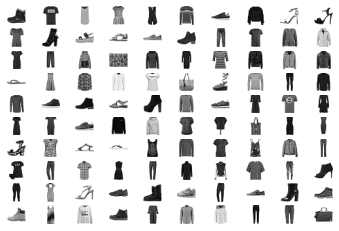

In [ ]:
# The example below plots the first 100 images from the training dataset in a 10 by 10 square.
from matplotlib import pyplot
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# plot images from the training dataset
for i in range(100):
	# define subplot
	pyplot.subplot(10, 10, 1 + i)
	# turn off axis
	pyplot.axis('off')
	# plot raw pixel data
	pyplot.imshow(trainX[i], cmap='gray_r')
pyplot.show()

In [ ]:
# from typing_extensions import Concatenate
# define discriminator model
def define_discriminator(in_shape=(28,28,1), n_classes=10):
  # label input
  in_label = Input(shape=(1,))
  # embedding for categorical input
  li = Embedding(n_classes, 50)(in_label)
  # scale up to image dimensions with linear activation
  n_nodes = in_shape[0] * in_shape[1]
  li = Dense(n_nodes)(li)
  # reshape to additional channel
  li = Reshape((in_shape[0], in_shape[1], 1))(li)
  # image input
  in_image = Input(shape=in_shape)
  # concat label as a channel
  merge = Concatenate()([in_image, li])
  # downsample
  fe = Conv2D(128, (3,3), strides = (2,2), padding='same')(merge)
  fe = LeakyReLU(alpha=0.2)(fe)
  # downsample
  fe = Conv2D(128, (3,3), strides = (2,2), padding='same')(fe)
  fe = LeakyReLU(alpha=0.2)(fe)
  # flatten feature maps
  fe = Flatten()(fe)
  # dropout
  fe = Dropout(0.4)(fe)
  # output
  out_layer = Dense(1, activation='sigmoid')(fe)
  # define model
  model = Model([in_image, in_label], out_layer)
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics=['accuracy'])
  return model


In [ ]:
# define generator model
def define_generator(latent_dim, n_classes=10):
  # label input
  in_label = Input(shape=(1,))
  # embedding for categorical input
  li = Embedding(n_classes, 50)(in_label)
  # linear multiplication
  n_nodes= 7*7
  li = Dense(n_nodes)(li)
  # reshape to additional channel
  li = Reshape((7,7,1))(li)
  # image generator input
  in_lat = Input(shape = (latent_dim,))
  # foundation for 7*7 image
  n_nodes = 128 * 7 * 7
  gen = Dense(n_nodes)(in_lat)
  gen = LeakyReLU(alpha=0.2)(gen)
  gen = Reshape((7, 7, 128))(gen)
  # merge image gen and label input
  merge = Concatenate()([gen, li])
  # unsample to 14*14
  gen = Conv2DTranspose(128, (4, 4), strides=(2,2), padding='same')(merge)
  gen = LeakyReLU(alpha=0.2)(gen)
  # unsample to 28*28
  gen = Conv2DTranspose(128, (4, 4), strides = (2,2), padding='same')(gen)
  gen = LeakyReLU(alpha=0.2)(gen)
  # output
  out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
  # define model
  model = Model([in_lat, in_label], out_layer)
  return model


In [ ]:
# define_gan() function below implements the conditional version of the GAN.

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
  # make weights in the discriminator not trainable
  d_model.trainable= False
  # get noise and label inputs from generator model
  gen_noise, gen_label = g_model.input
  # get img output from generator model
  gen_output = g_model.output
  # connect image output and label input from generator as inputs to discriminator
  gan_output = d_model([gen_output, gen_label])
  # define gan model as taking noise and label and outputting a classification
  model = Model([gen_noise, gen_label], gan_output)
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer = opt)
  return model

In [ ]:
# load fashion mnist images
def load_real_sample():
  # load dataset
  (trainX, trainy), (_, _) = load_data()
  # expand to 3d, e.g. add channels
  X = expand_dims(trainX, axis=-1)
  # convert from ints to floats
  X = X.astype('float32')
  # scale from [0, 255] to [-1, 1]
  X = (X - 127.5)/127.5
  return [X, trainy]


# select real samples
def generate_real_samples(dataset, n_samples):
  # split into images and labels
  images, labels = dataset
  # choose random instances
  ix = randint(0, images.shape[0], n_samples)
  # select images and labels
  X, labels = images[ix], labels[ix]
  # generate class labels
  y = ones((n_samples, 1))
  return [X, labels], y

In [ ]:
# generate poits in latent space as input for the generator
def generate_latent_points(latent_dim,n_samples, n_classes=10):
  # generate points inthe latent space
  x_input = randn(latent_dim * n_samples)
  # reshape into a batch of inputs for the network
  z_input = x_input.reshape(n_samples, latent_dim)
  # generate labels
  labels = randint(0, n_classes, n_samples)
  return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
  # generate points in latent space
  z_input, label_input = generate_latent_points(latent_dim, n_samples)
  # predict output
  images = generator.predict([z_input, label_input])
  # create class labels
  y = zeros((n_samples, 1))
  return [images, label_input], y

In [ ]:
# Finally, the train() function must be updated to retrieve and use the class labels in the calls to updating the discriminator and generator models.

In [ ]:
# train the generator and discriminato
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
  bat_per_epo = int(dataset[0].shape[0]/n_batch)
  half_batch = int(n_batch/2)
  # manually enumerate epochs
  for i in range(n_epochs):
    # enumerate batches over the training set
    for j in range(bat_per_epo):
      # get randomly selected 'real' samples
      [X_real, labels_real], y_real = generate_real_samples(dataset,half_batch)
      # update discriminator model weights
      d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
      # generate 'fake' examples
      [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      # update discriminator model weights
      d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
      # prepare points in latent space as input for generator
      [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
      # create inverted labels for the fake samples
      y_gan = ones((n_batch, 1))
      # update the generator via the discriminator's error
      g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
      # summarize loss on this batch
      print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
  # save the genrator model
  g_model.save('cgan_generator_.h5')

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_sample()
# train_model
train(g_model, d_model, gan_model, dataset, latent_dim)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Streaming output truncated to the last 5000 lines.
>90, 150/468, d1=0.683, d2=0.702 g=0.765
>90, 151/468, d1=0.661, d2=0.668 g=0.750
>90, 152/468, d1=0.681, d2=0.649 g=0.760
>90, 153/468, d1=0.692, d2=0.659 g=0.759
>90, 154/468, d1=0.713, d2=0.694 g=0.760
>90, 155/468, d1=0.705, d2=0.692 g=0.777
>90, 156/468, d1=0.646, d2=0.679 g=0.740
>90, 157/468, d1=0.684, d2=0.680 g=0.727
>90, 158/468, d1=0.675, d2=0.706 g=0.777
>90, 159/468, d1=0.702, d2=0.667 g=0.762
>90, 160/468, d1=0.704, d2=0.661 g=0.748
>90, 161/468, d1=0.662, d2=0.715 g=0.742
>90, 162/468, d1=0.651, d2=0.704 g=0.763
>90, 163/468, d1=0.671, d2=0.678 g=0.767
>90, 164/468, d1=0.681, d2=0.703 g=0.786
>90, 165/468, d1=0.689, d2=0.690 g=0.786
>90, 166/468, d1=0.726, d2=0.700 g=0.780
>90, 167/468, d1=0.685, d2=0.680 g=0.780
>90, 168/468, d1=0.668, d2=0.704 g=0.727
>90, 169/468, d1=0.646, d2=0.662 g=0.778
>90, 170/468, d1=0.683, d2=0.685 g=0.800
>90, 171/468, d1=0.689, d2=0.659 g=0.791
>90, 172/468, d1=0.673, d2=0.694 g=0.770
>90, 1

In [ ]:
# conditional clothing generation

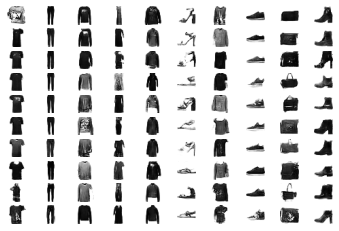

In [ ]:

# example of loading the generator model and generating images
from numpy import asarray
from matplotlib import pyplot
from keras.models import load_model

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network

	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]
 
# create and save a plot of generated images
def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.show()
 
# load model
model = load_model('cgan_generator_.h5')
# generate images
latent_points, labels = generate_latent_points(100, 100)
# specify labels
labels = asarray([x for _ in range(10) for x in range(10)])
# generate images
X  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
save_plot(X, 10)

In [ ]:

# The clothing is organized in columns From left to right, they are “t-shirt“, ‘trouser‘, ‘pullover‘, ‘dress‘, ‘coat‘, ‘sandal‘, ‘shirt‘, ‘sneaker‘, ‘bag‘, and ‘ankle boot‘.